# Plot and Save Learning Curves

In [1]:
import os
import copy

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision.io import read_image
from torchvision import datasets, models, transforms

from tqdm.notebook import trange, tqdm

## Current

In [2]:
ALL_MODEL_NAMES = [
    'baseline-2021-06-08',
    'baseline-2021-06-09',
    'baseline-Adam-2021-06-11',
    
    'Adam_wd=1e-08_2021-06-11',
    'Adam_wd=0.0001_2021-06-11',
    'Adam_wd=0.01_2021-06-11',
    'Adam_wd=1_2021-06-11',
    'Adam_wd=10_2021-06-11',
    'Adam_wd=100_2021-06-11',
    
    'strong-aug-Adam-2021-06-14',
    'strong-aug-longer-Adam-2021-06-14',
    'strong-aug-even-longer-Adam-2021-06-14',
    'strong-aug-not-so-long-Adam-2021-06-14',
    'strong-aug-not-so-long-Adam_wd=0.01_2021-06-14',
    'strong-aug-not-so-long-Adam_wd=0.1_2021-06-14',
    'strong-aug-not-so-long-Adam_wd=1_2021-06-14',
    'resnet18-strong-aug-Adam-last-layer-finetuned', # saved after deciding not to regularize last-layer fine-tuning
    'strong-aug-not-so-long-Adam_wd=10_2021-06-14',
    'strong-aug-not-so-long-Adam_wd=20_2021-06-14',
    'strong-aug-not-so-long-Adam_wd=40_2021-06-14',
# '2-layer-head-2021-06-15'
]

In [3]:
MODEL_NAME = 'strong-aug-not-so-long-Adam_wd=20_2021-06-14'

In [4]:
%ls ../history/

Adam_wd=0.0001_2021-06-11.json
Adam_wd=0.01_2021-06-11.json
Adam_wd=100_2021-06-11.json
Adam_wd=10_2021-06-11.json
Adam_wd=1_2021-06-11.json
Adam_wd=1e-08_2021-06-11.json
baseline-2021-06-08.json
baseline-2021-06-09.json
baseline-Adam-2021-06-11.json
dummy-classifier.json
resnet18-strong-aug-Adam-last-layer-finetuned.json
strong-aug-Adam-2021-06-14.json
strong-aug-even-longer-Adam-2021-06-14.json
strong-aug-longer-Adam-2021-06-14.json
strong-aug-not-so-long-Adam-2021-06-14.json
strong-aug-not-so-long-Adam_wd=0.01_2021-06-14.json
strong-aug-not-so-long-Adam_wd=0.1_2021-06-14.json
strong-aug-not-so-long-Adam_wd=10_2021-06-14.json
strong-aug-not-so-long-Adam_wd=1_2021-06-14.json
strong-aug-not-so-long-Adam_wd=20_2021-06-14.json
strong-aug-not-so-long-Adam_wd=40_2021-06-14.json


### Plot and Save Learning Curves

In [5]:
with open(f'../history/{MODEL_NAME}.json') as f:
    history = json.load(f)
    
with open(f'../history/dummy-classifier.json') as f:
    dummy = json.load(f)

In [6]:
dummy

{'loss_w_all_one_half_probs': 2.7725887298583984,
 'train_per_class_accuracies': [0.7953125238418579,
  0.7875000238418579,
  0.7734375,
  0.637499988079071],
 'dev_per_class_accuracies': [0.785937488079071,
  0.7906249761581421,
  0.776562511920929,
  0.6343749761581421],
 'train_average_accuracy': 0.7484375238418579,
 'dev_average_accuracy': 0.7468749284744263}

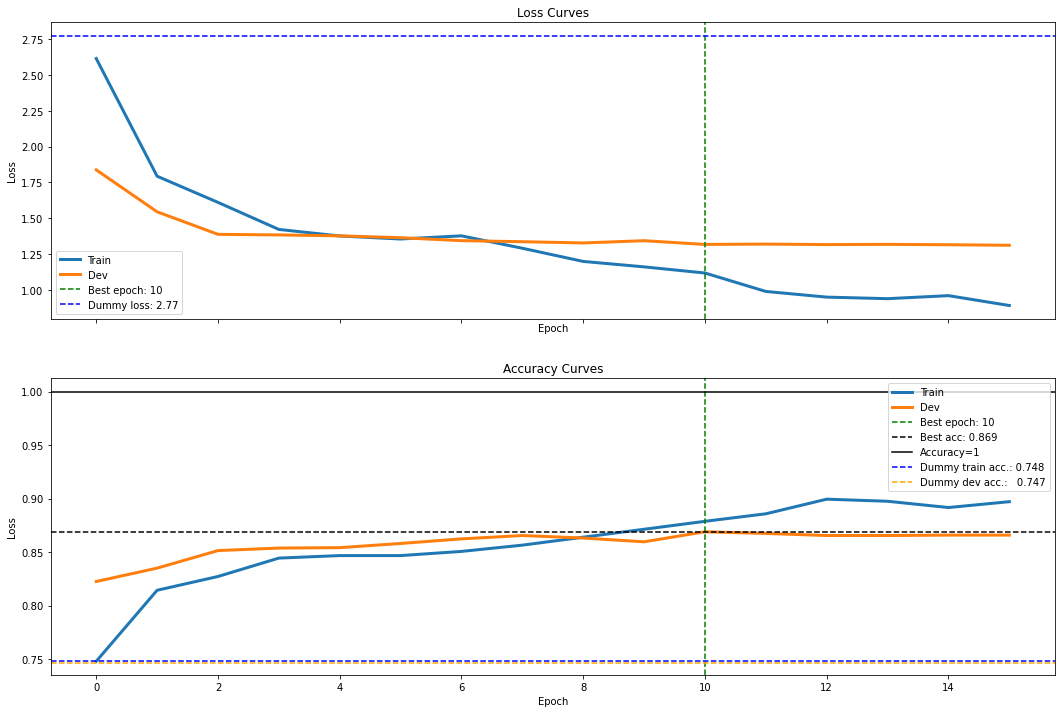

In [7]:
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(18, 12))


ax1.plot(np.arange(len(history['train_losses'])), history['train_losses'], label=f'Train', linewidth=3)
ax1.plot(np.arange(len(history['dev_losses'])), history['dev_losses'], label=f'Dev', linewidth=3)

ax1.axvline(x=history['best_epoch'], label=f"Best epoch: {history['best_epoch']}", color='green', ls='--')
ax1.axhline(y=dummy['loss_w_all_one_half_probs'], label=f"Dummy loss: {dummy['loss_w_all_one_half_probs']:.3}", color='blue', ls='--')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title("Loss Curves")
ax1.legend(loc='best')

ax2.plot(np.arange(len(history['train_average_accuracies'])), history['train_average_accuracies'], label=f'Train', linewidth=3)
ax2.plot(np.arange(len(history['dev_average_accuracies'])), history['dev_average_accuracies'], label=f'Dev', linewidth=3)
ax2.axvline(x=history['best_epoch'], label=f"Best epoch: {history['best_epoch']}", color='green', ls='--')
ax2.axhline(y=history['best_acc'], label=f"Best acc: {history['best_acc']:.3}", color='black', ls='--')
ax2.axhline(y=1, label=f"Accuracy=1", color='black', ls='-')
ax2.axhline(y=dummy['train_average_accuracy'], label=f"Dummy train acc.: {dummy['train_average_accuracy']:.3}", color='blue', ls='--')
ax2.axhline(y=dummy['dev_average_accuracy'], label=f"Dummy dev acc.:   {dummy['dev_average_accuracy']:.3}", color='orange', ls='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title(f"Accuracy Curves")

ax2.legend(loc='best')

plt.savefig(f'../learning_curves/{MODEL_NAME}.png', dpi=300, bbox_inches='tight')
plt.show()

### Results

In [8]:
# sanity check
assert np.max(history['dev_average_accuracies']) == history['best_acc']
assert np.argmax(history['dev_average_accuracies']) == history['best_epoch']

In [9]:
bias = 1 - np.max(history['train_average_accuracies'])
variance = np.max(history['train_average_accuracies']) - history['dev_average_accuracies'][history['best_epoch']]

print("### Results\n")
print(f"* Bayes acc: {1.:.3}")
print(f"* Train acc: {np.max(history['train_average_accuracies']):.3}")
print(f"* Dev acc:   {history['best_acc']:.3}")
print("\n**Train acc.**")
print("\n**Dev acc.**")
print("\n**Overall.**")

print('\n\n### Bias-Varience\n')
print(f"* Bias:      {bias:.3}")
print(f"* Variance:  {variance:.3}")
print("\n**Bias.**")
print("\n**Variance.**")
print("\n**Overall.**")

print("\n### Next Step")

### Results

* Bayes acc: 1.0
* Train acc: 0.9
* Dev acc:   0.869

**Train acc.**

**Dev acc.**

**Overall.**


### Bias-Varience

* Bias:      0.1
* Variance:  0.0305

**Bias.**

**Variance.**

**Overall.**

### Next Step


In [10]:
# # plot losses
# plt.figure(figsize=(18, 9))
# plt.plot(np.arange(len(history['train_losses'])), history['train_losses'], label=f'Train', linewidth=3)
# plt.plot(np.arange(len(history['dev_losses'])), history['dev_losses'], label=f'Dev', linewidth=3)
# plt.axvline(x=history['best_epoch'], label=f"Best epoch: {history['best_epoch']}", color='red', ls='--')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title("Loss Curves")
# plt.legend(loc='best')
# plt.show()

In [11]:
# # plot accuracies
# plt.figure(figsize=(18, 9))
# plt.plot(np.arange(len(history['train_average_accuracies'])), history['train_average_accuracies'], label=f'Train', linewidth=3)
# plt.plot(np.arange(len(history['dev_average_accuracies'])), history['dev_average_accuracies'], label=f'Dev', linewidth=3)
# plt.axvline(x=history['best_epoch'], label=f"Best epoch: {history['best_epoch']}", color='red', ls='--')
# plt.axhline(y=history['best_acc'], label=f"Best acc: {history['best_acc']:.3}", color='black', ls='--')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title(f"Accuracy Curves")
# plt.legend(loc='best')
# plt.show()

## All

In [12]:
with open(f'../history/dummy-classifier.json') as f:
    dummy = json.load(f)

In [13]:
dummy

{'loss_w_all_one_half_probs': 2.7725887298583984,
 'train_per_class_accuracies': [0.7953125238418579,
  0.7875000238418579,
  0.7734375,
  0.637499988079071],
 'dev_per_class_accuracies': [0.785937488079071,
  0.7906249761581421,
  0.776562511920929,
  0.6343749761581421],
 'train_average_accuracy': 0.7484375238418579,
 'dev_average_accuracy': 0.7468749284744263}

In [14]:
# Turn interactive plotting off
plt.ioff()

baseline-2021-06-08


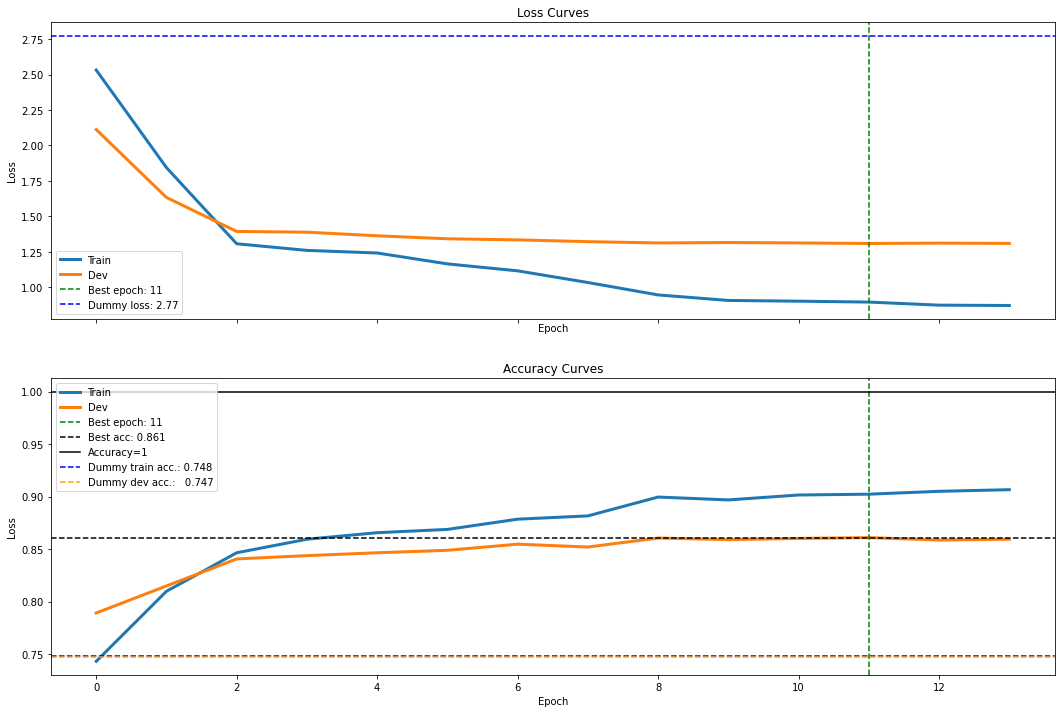

baseline-2021-06-09


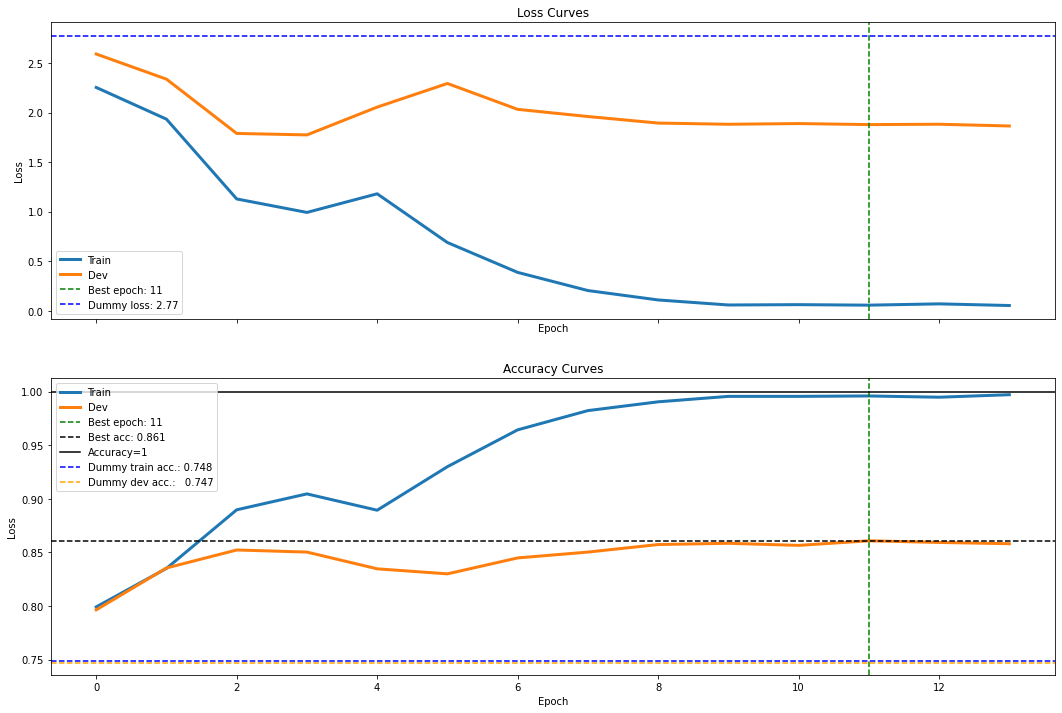

baseline-Adam-2021-06-11


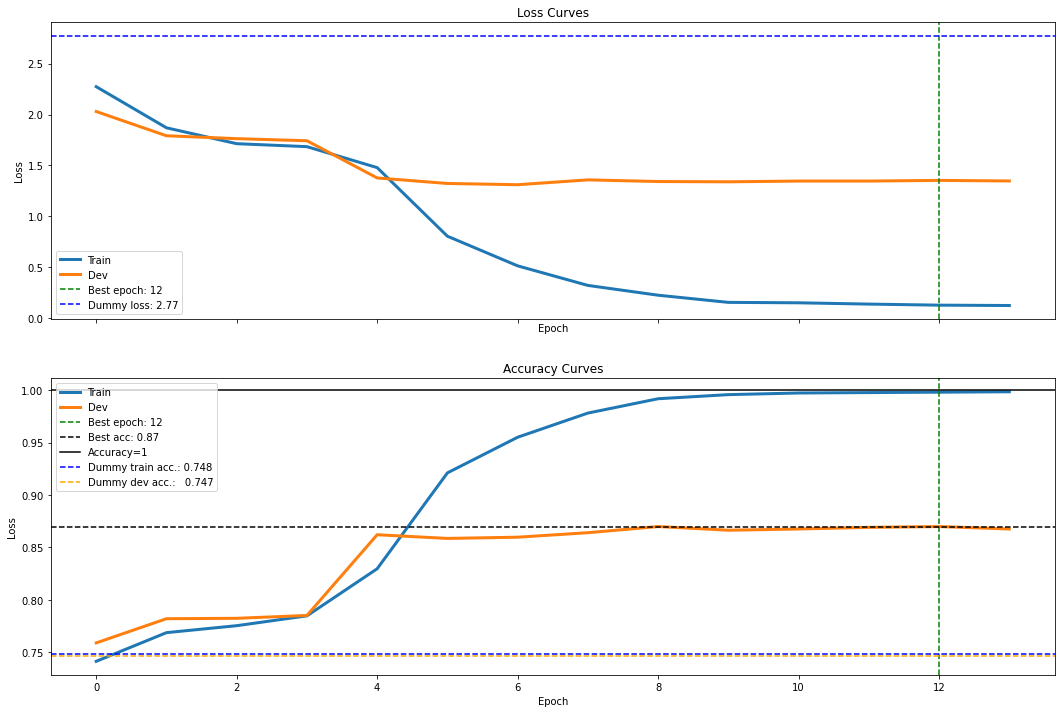

Adam_wd=1e-08_2021-06-11


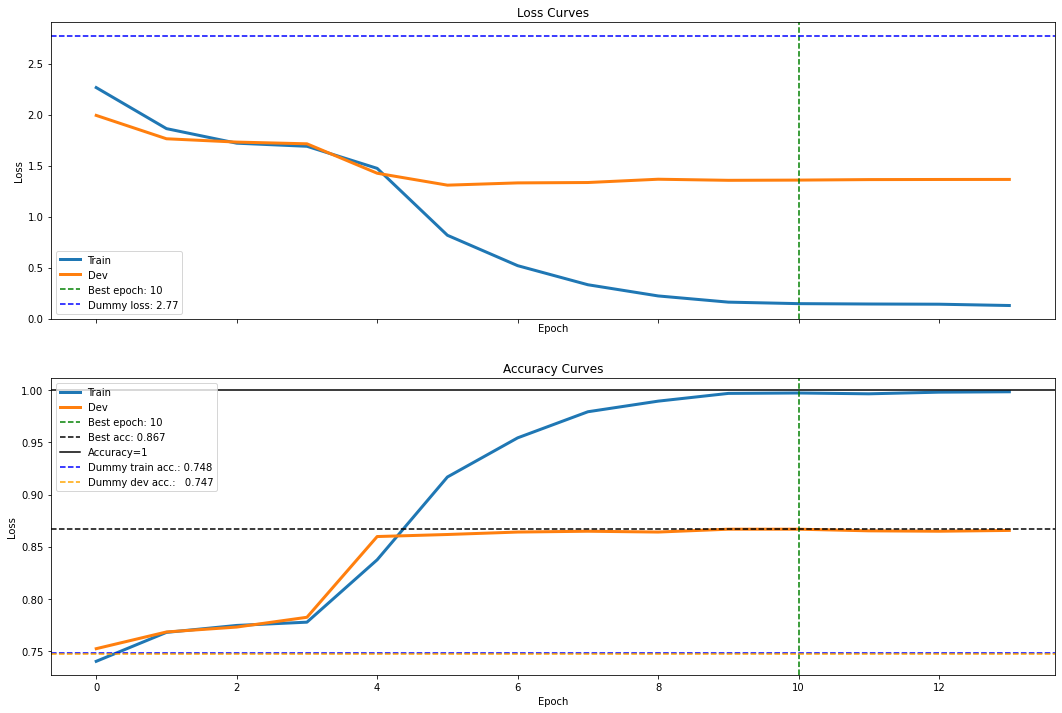

Adam_wd=0.0001_2021-06-11


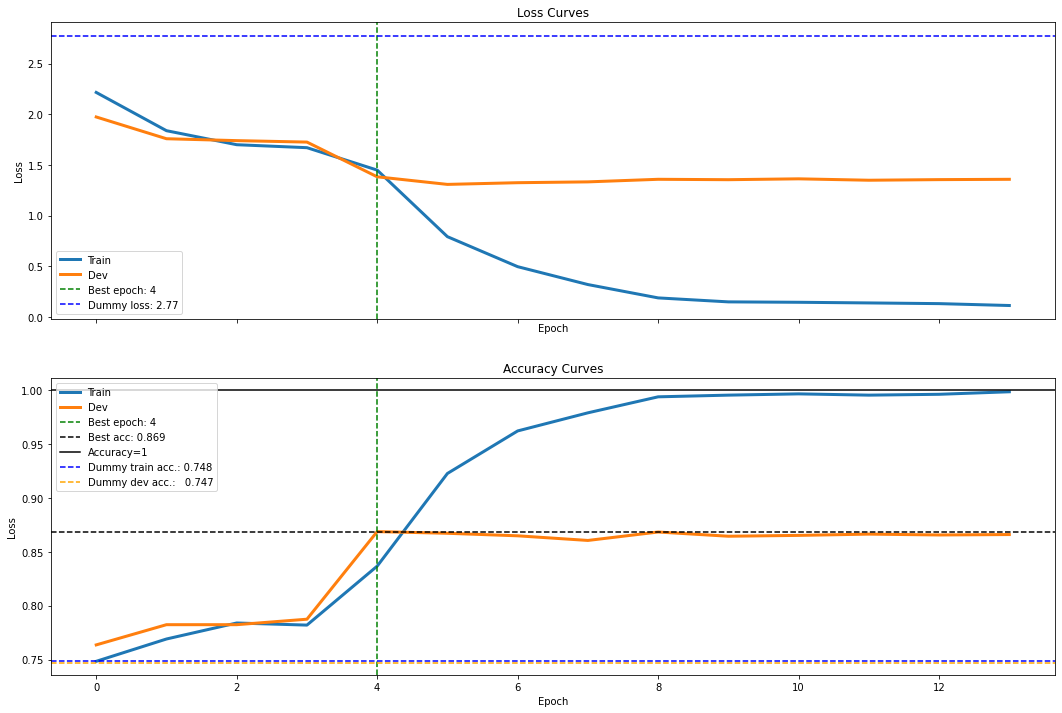

Adam_wd=0.01_2021-06-11


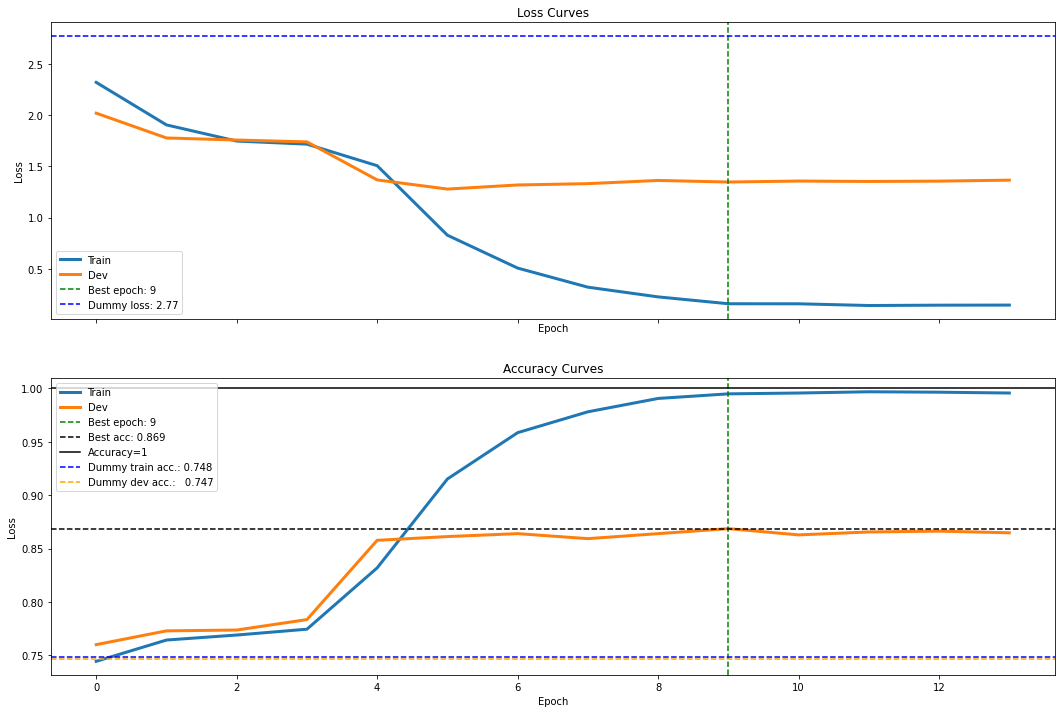

Adam_wd=1_2021-06-11


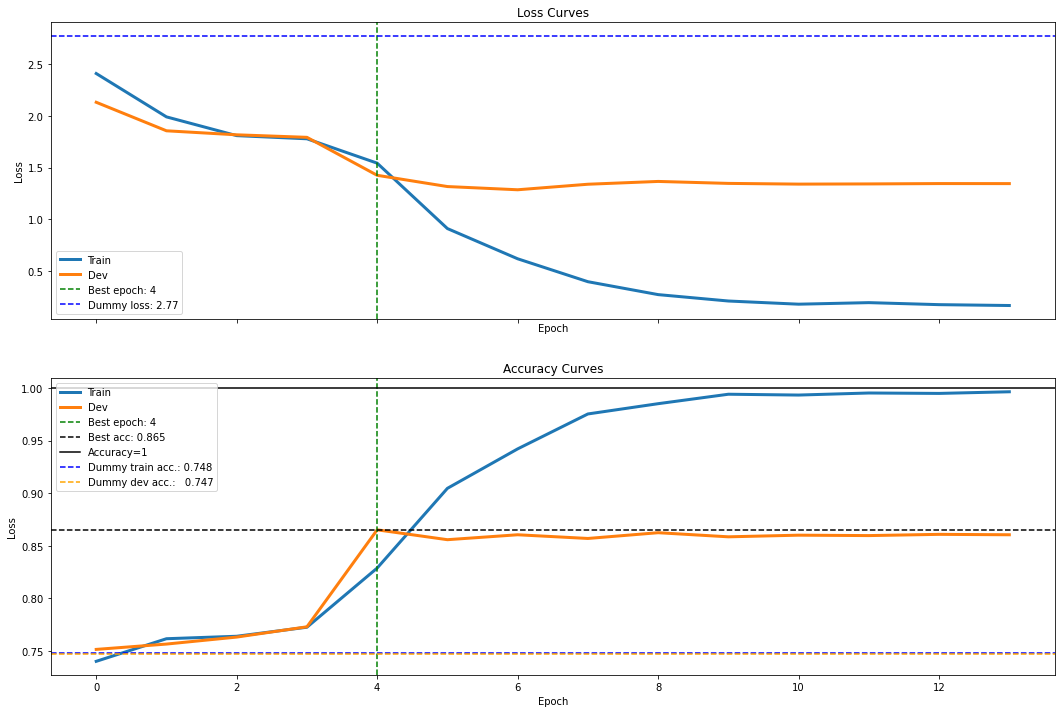

Adam_wd=10_2021-06-11


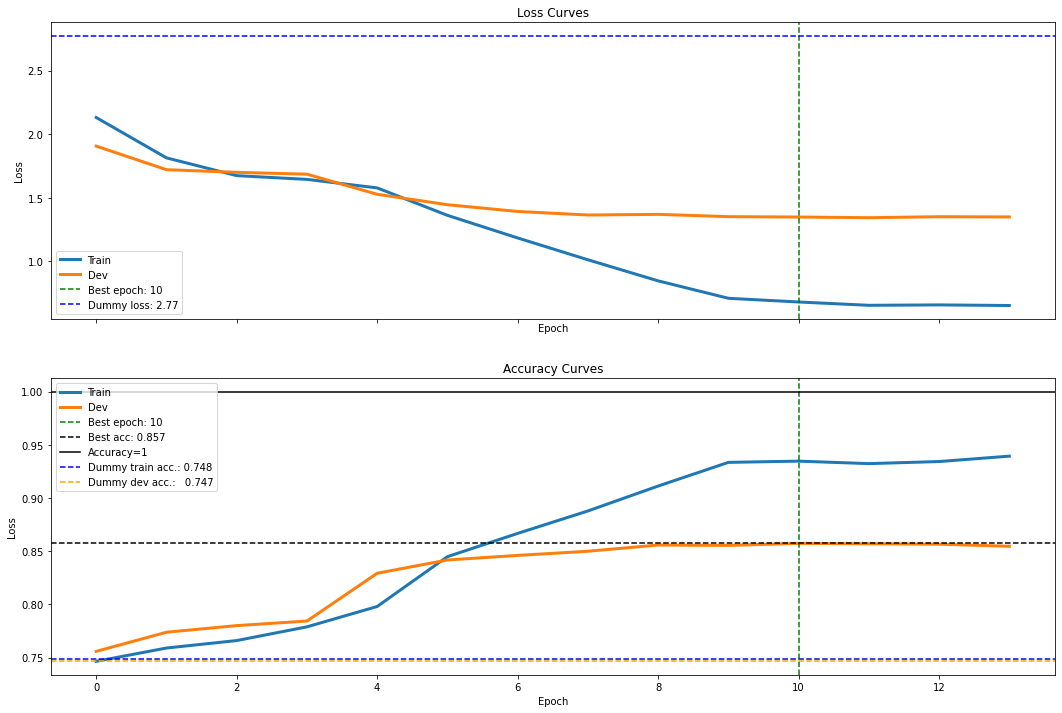

Adam_wd=100_2021-06-11


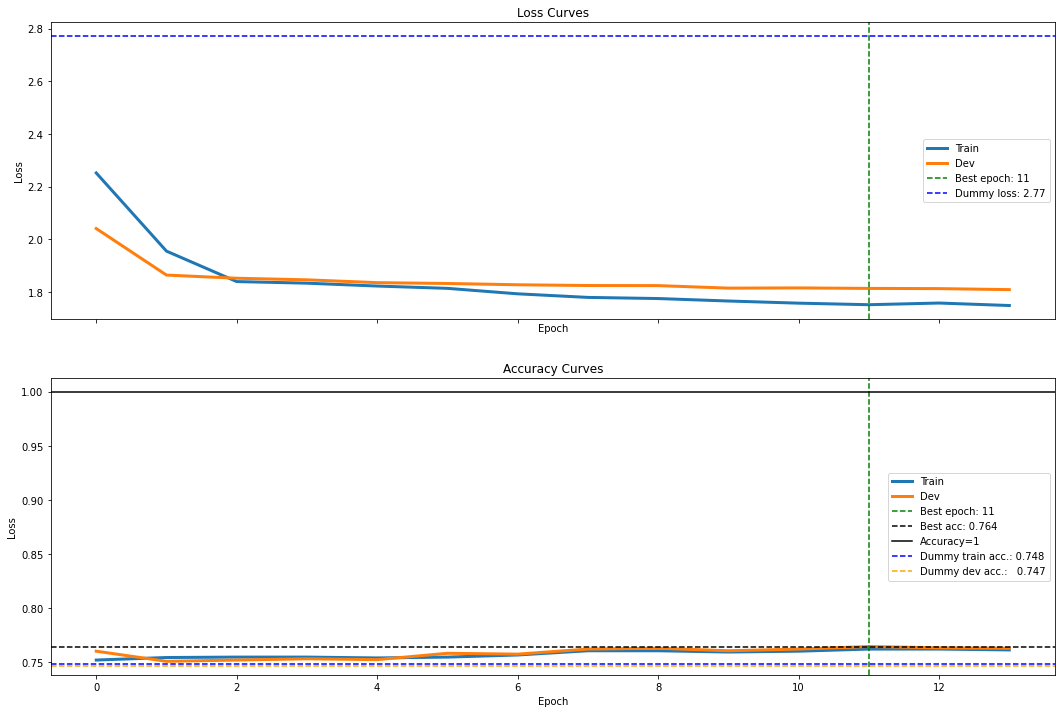

strong-aug-Adam-2021-06-14


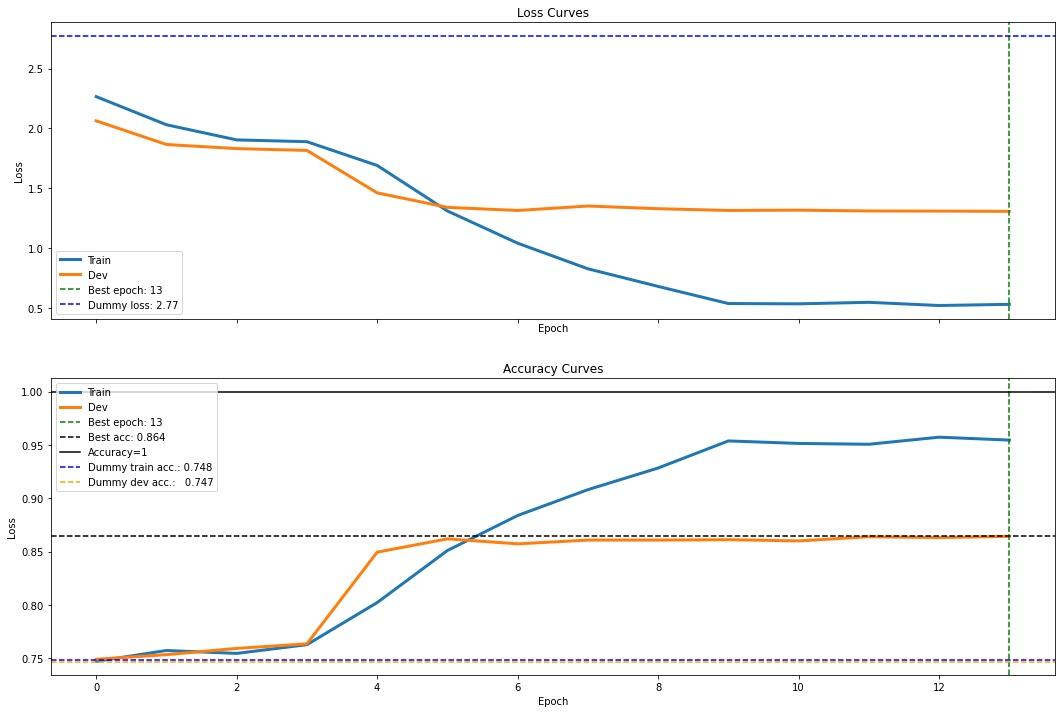

strong-aug-longer-Adam-2021-06-14


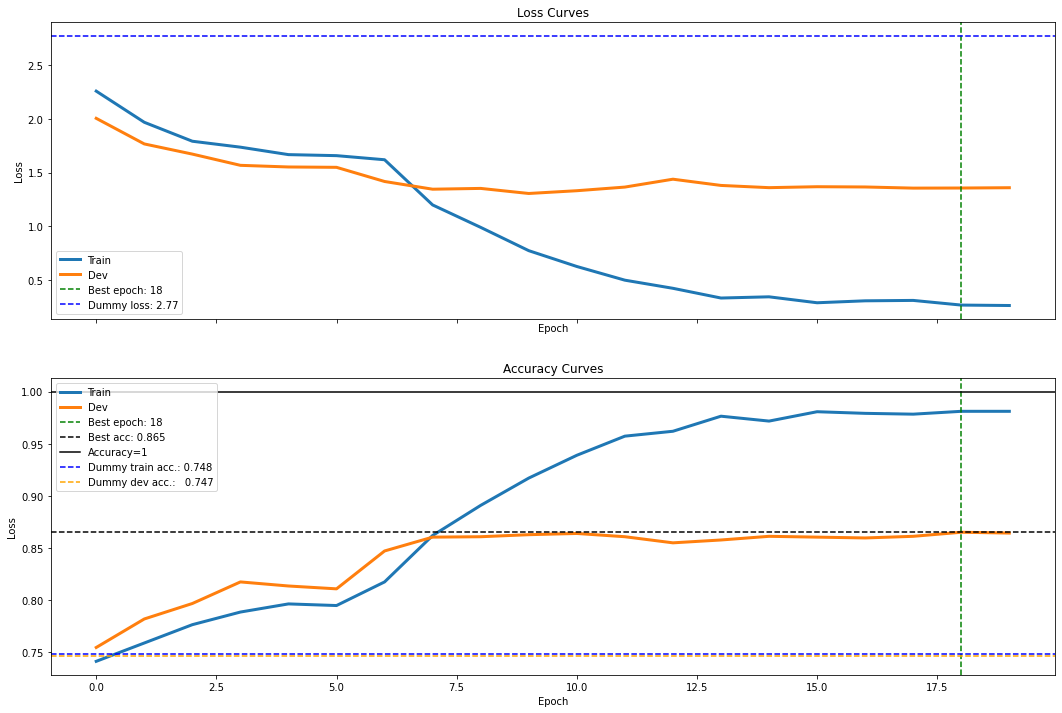

strong-aug-even-longer-Adam-2021-06-14


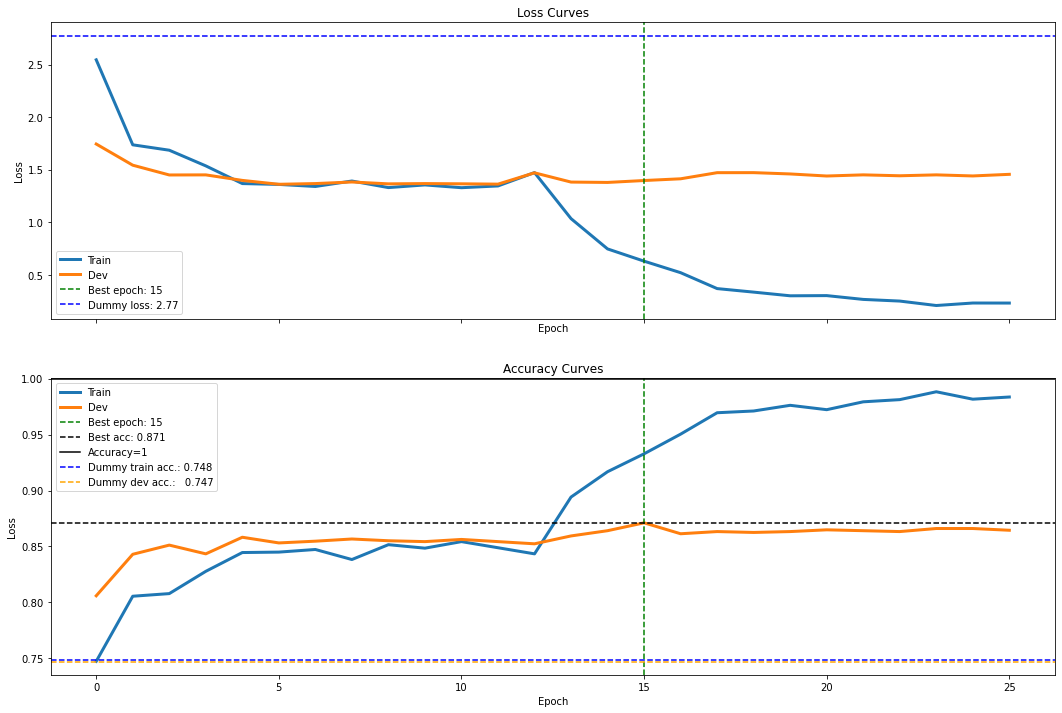

strong-aug-not-so-long-Adam-2021-06-14


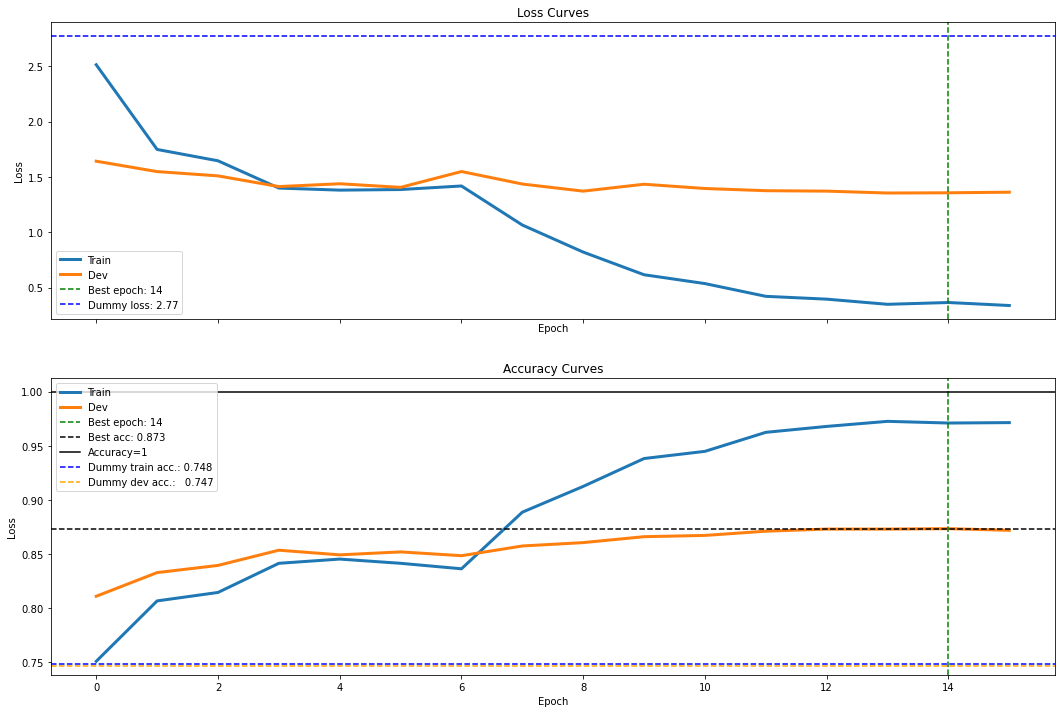

strong-aug-not-so-long-Adam_wd=0.01_2021-06-14


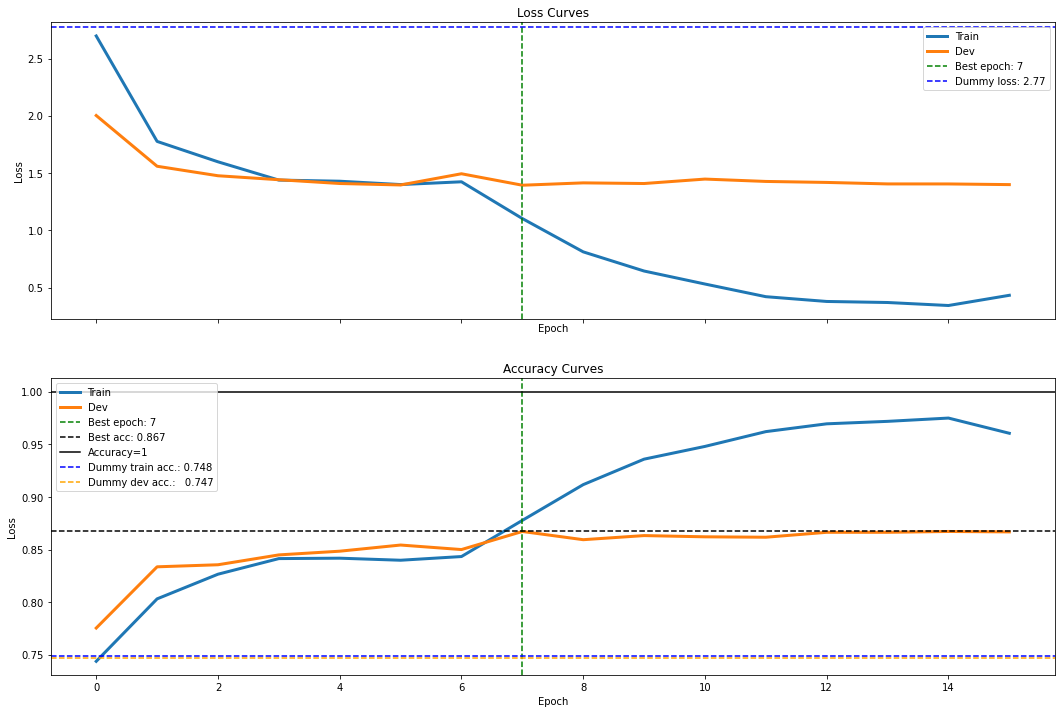

strong-aug-not-so-long-Adam_wd=0.1_2021-06-14


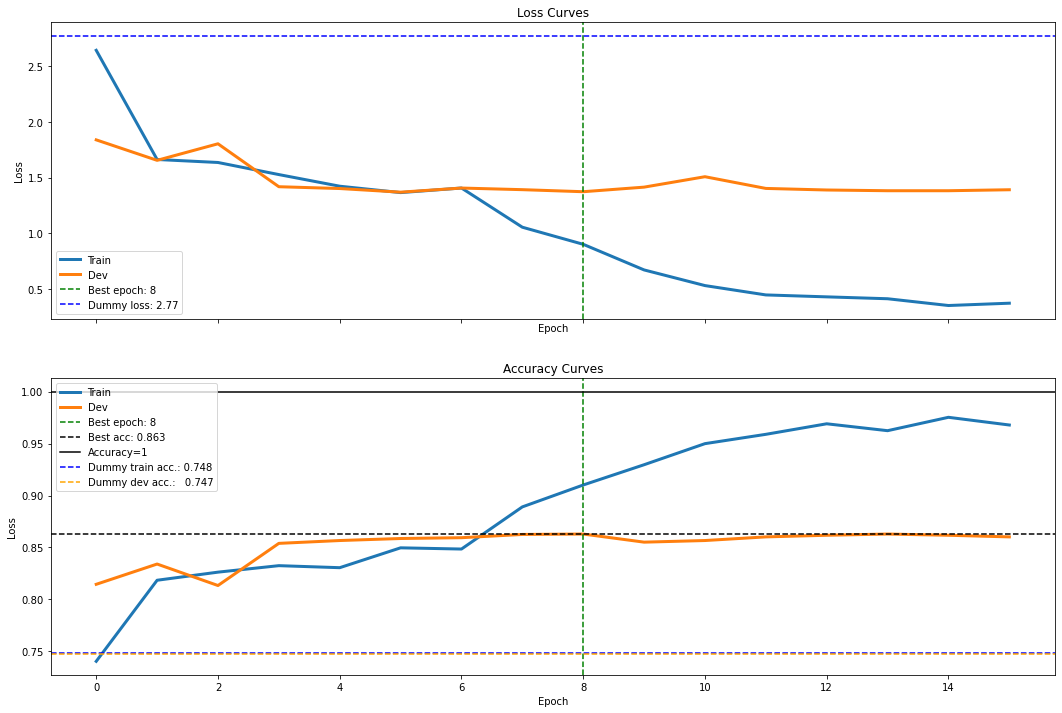

strong-aug-not-so-long-Adam_wd=1_2021-06-14


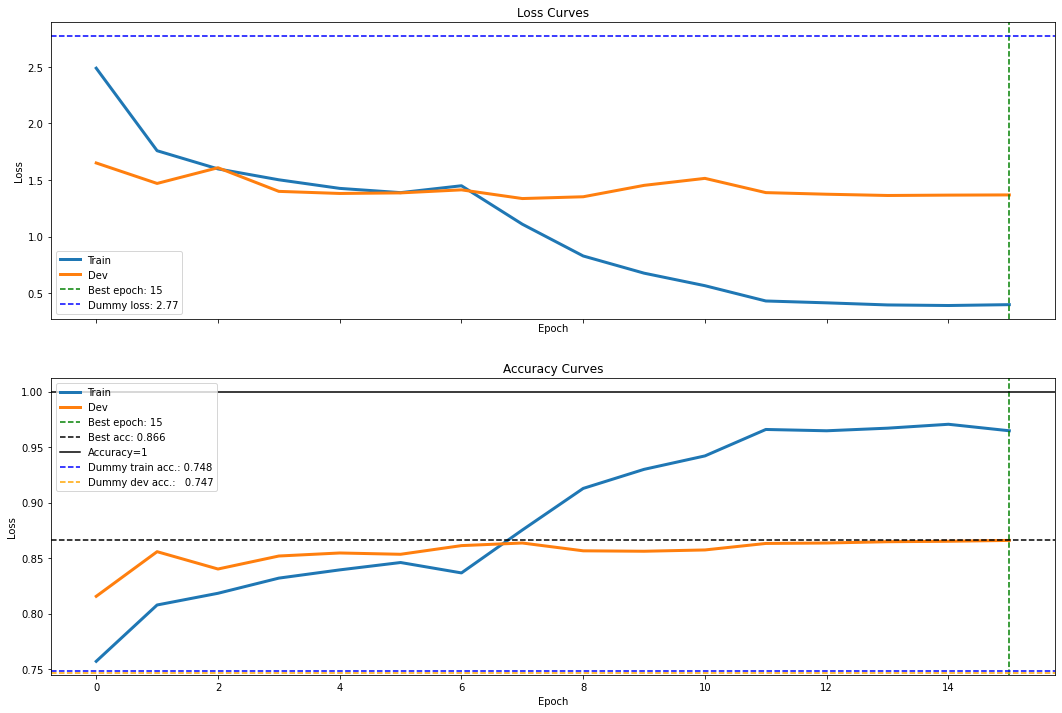

resnet18-strong-aug-Adam-last-layer-finetuned


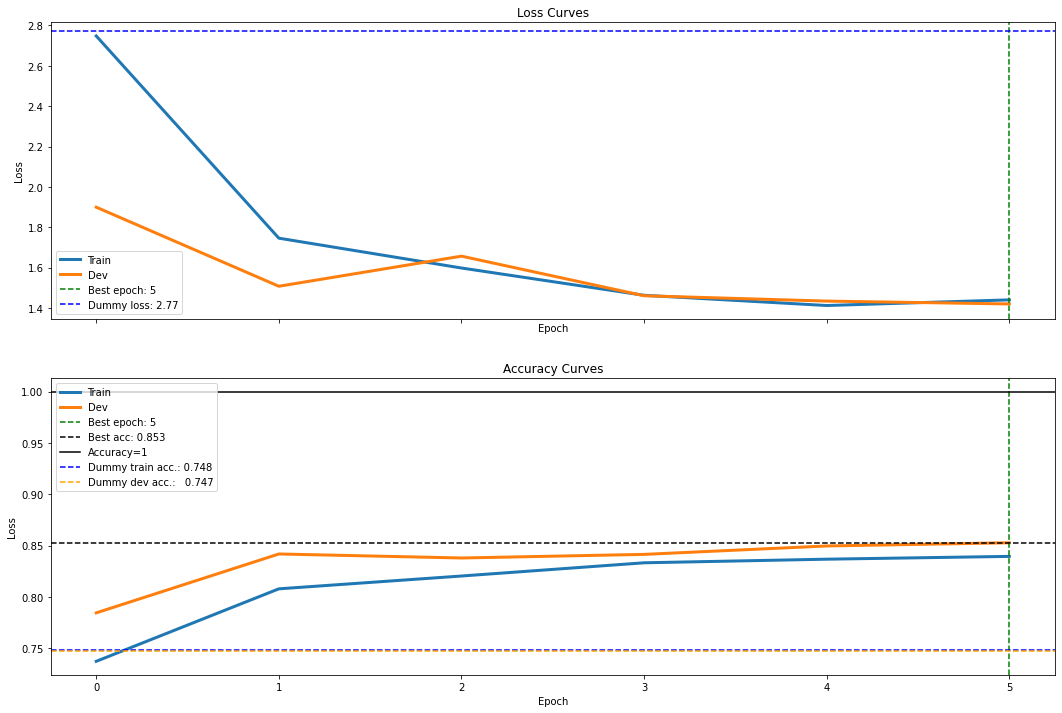

strong-aug-not-so-long-Adam_wd=10_2021-06-14


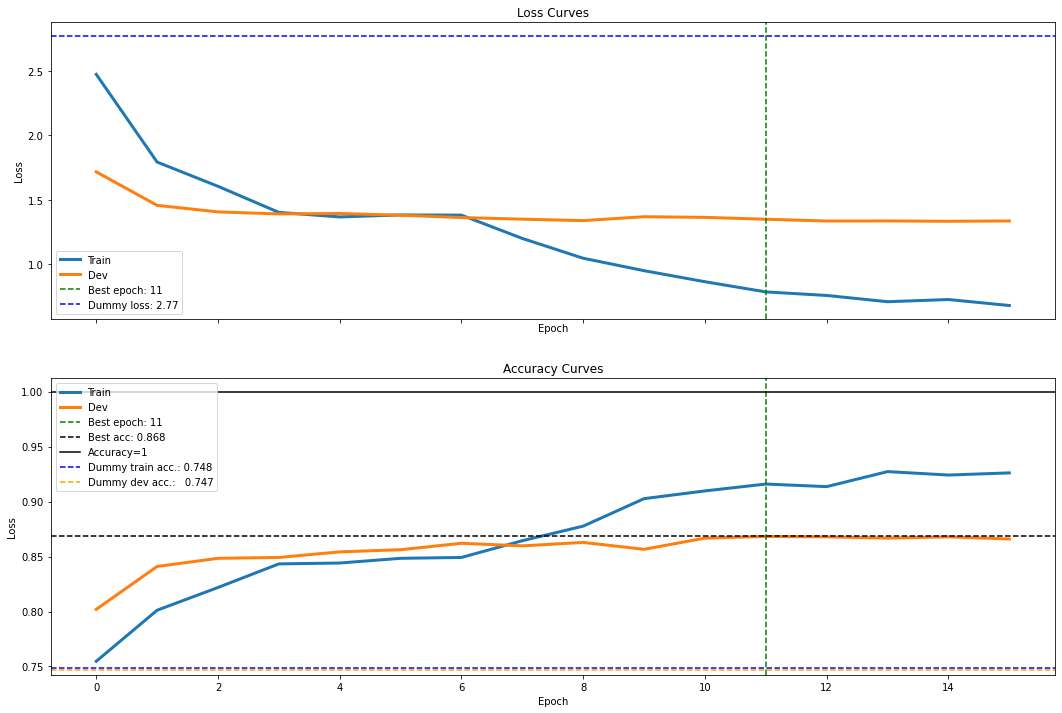

strong-aug-not-so-long-Adam_wd=20_2021-06-14


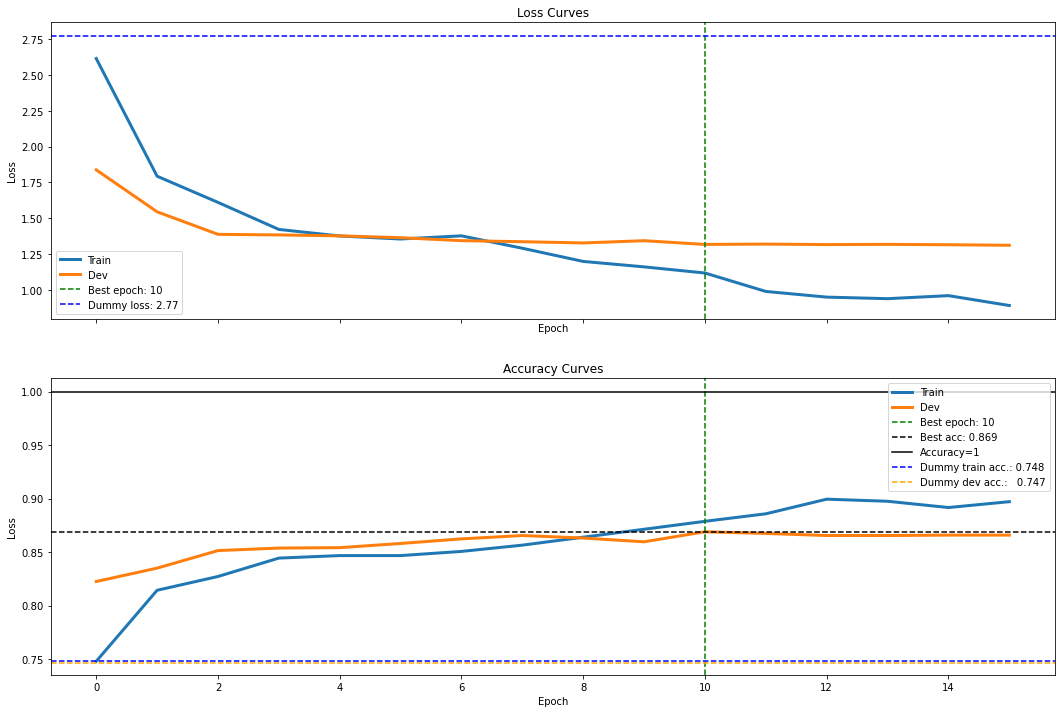

strong-aug-not-so-long-Adam_wd=40_2021-06-14


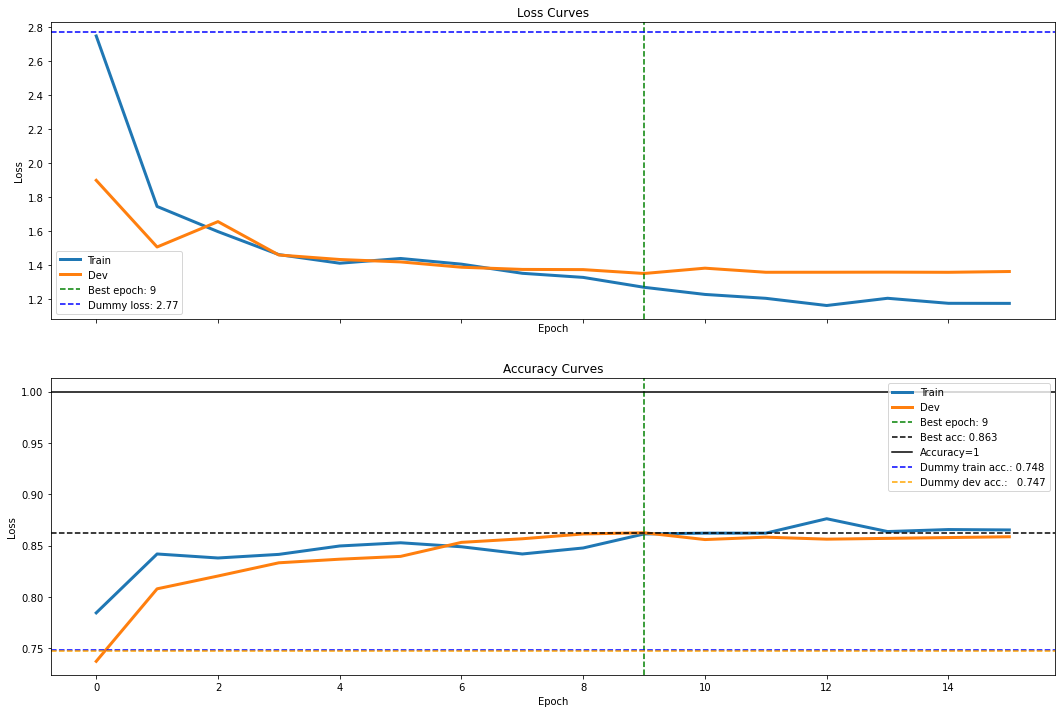

All done.


In [15]:
summary = {}

# results for dummy classifier
summary['dummy-classifier'] = {}
summary['dummy-classifier']['Train acc'] = dummy['train_average_accuracy']
summary['dummy-classifier']['Dev acc'] = dummy['dev_average_accuracy']
summary['dummy-classifier']['Bias'] = 1 - dummy['train_average_accuracy']
summary['dummy-classifier']['Variance'] = dummy['train_average_accuracy'] - dummy['dev_average_accuracy']

# results for all the models
for model_name in ALL_MODEL_NAMES:
    print(model_name)
    
    # initialise the dict to save it all into
    summary[model_name] = {}
    
    # load history
    with open(f'../history/{model_name}.json') as f:
        history = json.load(f)
    
    
    # plot learning curves
    f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(18, 12))

    ax1.plot(np.arange(len(history['train_losses'])), history['train_losses'], label=f'Train', linewidth=3)
    ax1.plot(np.arange(len(history['dev_losses'])), history['dev_losses'], label=f'Dev', linewidth=3)

    ax1.axvline(x=history['best_epoch'], label=f"Best epoch: {history['best_epoch']}", color='green', ls='--')
    ax1.axhline(y=dummy['loss_w_all_one_half_probs'], label=f"Dummy loss: {dummy['loss_w_all_one_half_probs']:.3}", color='blue', ls='--')

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title("Loss Curves")
    ax1.legend(loc='best')

    ax2.plot(np.arange(len(history['train_average_accuracies'])), history['train_average_accuracies'], label=f'Train', linewidth=3)
    ax2.plot(np.arange(len(history['dev_average_accuracies'])), history['dev_average_accuracies'], label=f'Dev', linewidth=3)
    ax2.axvline(x=history['best_epoch'], label=f"Best epoch: {history['best_epoch']}", color='green', ls='--')
    ax2.axhline(y=history['best_acc'], label=f"Best acc: {history['best_acc']:.3}", color='black', ls='--')
    ax2.axhline(y=1, label=f"Accuracy=1", color='black', ls='-')
    ax2.axhline(y=dummy['train_average_accuracy'], label=f"Dummy train acc.: {dummy['train_average_accuracy']:.3}", color='blue', ls='--')
    ax2.axhline(y=dummy['dev_average_accuracy'], label=f"Dummy dev acc.:   {dummy['dev_average_accuracy']:.3}", color='orange', ls='--')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title(f"Accuracy Curves")

    ax2.legend(loc='best')

    plt.savefig(f'../learning_curves/{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # sanity check
    assert np.max(history['dev_average_accuracies']) == history['best_acc']
    assert np.argmax(history['dev_average_accuracies']) == history['best_epoch']
    
    # calculate bias and variance
    bias = 1 - np.max(history['train_average_accuracies'])
    variance = np.max(history['train_average_accuracies']) - history['dev_average_accuracies'][history['best_epoch']]
     
    # record the results
    summary[model_name]['Train acc'] = np.max(history['train_average_accuracies'])
    summary[model_name]['Dev acc'] = history['best_acc']
    summary[model_name]['Bias'] = bias
    summary[model_name]['Variance'] = variance

print("All done.")

In [16]:
summary_df = pd.DataFrame(summary).T.round(3) * 100
display(summary_df)

,Train acc,Dev acc,Bias,Variance
dummy-classifier,74.8,74.7,25.2,0.2
baseline-2021-06-08,90.7,86.1,9.3,4.6
baseline-2021-06-09,99.7,86.1,0.3,13.6
baseline-Adam-2021-06-11,99.8,87.0,0.2,12.9
Adam_wd=1e-08_2021-06-11,99.8,86.7,0.2,13.2
Adam_wd=0.0001_2021-06-11,99.8,86.9,0.2,13.0
Adam_wd=0.01_2021-06-11,99.7,86.9,0.3,12.8
Adam_wd=1_2021-06-11,99.6,86.5,0.4,13.1
Adam_wd=10_2021-06-11,93.9,85.7,6.1,8.2
Adam_wd=100_2021-06-11,76.2,76.4,23.8,-0.2


In [17]:
summary_df.to_csv('../results/summary.csv')